In [4]:
import pandas as pd
import pingouin as pg
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt

## Data reading & preprocessing

In [5]:
dataset = pd.read_csv("data/dataset.csv", header=0, index_col=[0])

In [6]:
# dataset = pd.read_csv("v2_dataset0702.csv", header=0, index_col=[0])
dataset = dataset[~dataset.email.duplicated()]
long = dataset.melt(['email', 'answers', 'group', 'date'])
long.loc[long.variable.str.contains('C'), 'type'] = 'CODING'
long.loc[long.variable.str.contains('D'), 'type'] = 'DEBUGGING'
long['intervention'] = long.variable.str.split('_').apply(lambda x: 'pre' if int(x[1]) == 1 else 'post')

groups = {
    "[4, 0, 3, 7]": 0,  # False
    "[0, 4, 7, 3]": 1,  # False
    "[1, 5, 2, 6]": 2,  # True
    "[5, 1, 6, 2]": 3,  # True
}
long.group = long.group.replace(groups)

key = [True, True, False, False]
key_df = pd.DataFrame(key, columns=['is_ZenMode']).reset_index()
long = long.merge(key_df, left_on='group', right_on='index')
long.loc[long.intervention == 'post', ['is_ZenMode']] = ~long.loc[long.intervention == 'post', ['is_ZenMode']]

long.variable = long.variable.str.replace(r'(C|D)_\d_', '', regex=True)
long = long.pivot(index=['email', 'answers', 'group', 'date', 'is_ZenMode', 'intervention'],
                  columns=['type', 'variable'], values='value')

In [7]:
long = long.reset_index()
columns = long.columns

new_columns = []
for col in columns:
    if col[1] == '':
        new_col = 'util_' + col[0].lower()
    else:
        new_col = col[0].lower() + '_'+ col[1].lower()
    new_columns.append(new_col)

long.columns = new_columns

In [8]:
df = long

In [9]:
# str to timedelta
time_columns = ['coding_time', 'coding_first_symbol_time', 'debugging_time', 'debugging_first_bug_time']
df[time_columns] = df[time_columns].apply(pd.to_timedelta)

for col in time_columns:
    df[col] = df[col].dt.total_seconds()

In [10]:
df['util_answers'] = df['util_answers'].apply(lambda x: [int(i) for i in x[1:-1].split(', ')])
df['adhd'] = df['util_answers'].apply(lambda x: sum(x))

# group as a sum of answers in scales
df['management_sum'] = df['util_answers'].apply(lambda x: 1 if sum(x[:4]) > 8 else 0)
df['organization_sum'] = df['util_answers'].apply(lambda x: 1 if sum(x[4:8]) > 8 else 0)
df['restraint_sum'] = df['util_answers'].apply(lambda x: 1 if sum(x[8:12]) > 8 else 0)
df['motivation_sum'] = df['util_answers'].apply(lambda x: 1 if sum(x[12:17]) > 8 else 0)
df['regulation_sum'] = df['util_answers'].apply(lambda x: 1 if sum(x[17:]) > 8 else 0)

# sum of answers in scales
df['management_value'] = df['util_answers'].apply(lambda x: sum(x[:4]))
df['organization_value'] = df['util_answers'].apply(lambda x: sum(x[4:8]))
df['restraint_value'] = df['util_answers'].apply(lambda x: sum(x[8:12]))
df['motivation_value'] = df['util_answers'].apply(lambda x: sum(x[12:17]))
df['regulation_value'] = df['util_answers'].apply(lambda x: sum(x[17:]))

In [11]:
coding_factors = [i for i in df.columns if 'coding_' in i]
coding_factors.remove('coding_snapshot')
coding_factors.remove('coding_coding_speed_result')
df[coding_factors] = df[coding_factors].astype(float)

debugging_factors = [i for i in df.columns if 'debugging_' in i]
debugging_factors.remove('debugging_snapshot')
df[debugging_factors] = df[debugging_factors].astype(float)

In [12]:
# compute deltas
code_factors_deltas = df.loc[df.util_is_zenmode == False, coding_factors].reset_index(drop=True).\
    divide(df.loc[df.util_is_zenmode == True, coding_factors].reset_index(drop=True), fill_value=0).round(2)
code_factors_deltas['util_email'] = df.loc[df.util_is_zenmode == False, 'util_email'].reset_index(drop=True)

debugging_factors_deltas = df.loc[df.util_is_zenmode == False, debugging_factors].reset_index(drop=True).\
    divide(df.loc[df.util_is_zenmode == True, debugging_factors].reset_index(drop=True), fill_value=0).round(2)
debugging_factors_deltas['util_email'] = df.loc[df.util_is_zenmode == False, 'util_email'].reset_index(drop=True)

In [15]:
descriptive_code = df.groupby('util_is_zenmode')[coding_factors].describe().transpose().stack().unstack(level=1).round(2).copy()
descriptive_code = descriptive_code.rename(index={'coding_time': 'Total time (sec)',
                                                  'coding_first_symbol_time': 'Time of input of the first character (sec)',
                                                    'coding_time_for_row': 'Average time for one line of code (sec)',
                                                    'coding_coding_speed_all': 'Speed (diff/sec)',
                                                    'coding_edits': 'Number of deletions',
                                                    'coding_events_count': 'Number of actions',
                                                    'coding_rows': 'Number of lines in the solution'})


In [18]:
descriptive_debug = df.groupby('util_is_zenmode')[debugging_factors].describe().transpose().stack().unstack(level=1).round(2).copy()
descriptive_debug = descriptive_debug.rename(index={'debugging_time': 'Total time (sec)',
                                                    'debugging_first_bug_time': 'Time of the first bug fix (sec)',
                                                    'debugging_diffs': 'Number of changes in the snippet',
                                                    'debugging_events_count': 'Number of actions',
                                                    'debugging_fixed_bugs': 'Number of fixed bugs'})


In [20]:
adhd_value_measures = [i for i in df.columns if '_value' in i]
adhd_measures = [i for i in df.columns if '_sum' in i]

descriptive_scale_raw = df.loc[df['util_is_zenmode']==True]
descriptive_scale = descriptive_scale_raw[adhd_value_measures].describe().transpose().round(2).copy()
sum_scale = descriptive_scale_raw[adhd_measures].sum()
descriptive_scale['symptom'] = sum_scale.values.tolist()
descriptive_scale['count'] = descriptive_scale['count'].astype(int)
descriptive_scale = descriptive_scale.rename(index={'management_value': 'Time management',
                                                    'organization_value': 'Self-organization',
                                                    'restraint_value': 'Self-restraint',
                                                    'motivation_value': 'Self-motivation',
                                                    'regulation_value': 'Self-regulation of emotions'})
descriptive_scale = descriptive_scale[['count', 'symptom', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', ]]

## Hypothesis 1
#### There is a difference in efficiency measures depending on the perceptual load of the IDE


In [111]:
# tasks results for all participants with and without Zen Mode
zen_mode = df.loc[df.util_is_zenmode == True]
normal_mode = df.loc[df.util_is_zenmode == False]

In [122]:
ttest_factors = []

In [123]:
def ttest_results(efficiency_factors, h_alternative):
    """
    Computes One Sided Paired T-tes and print stats if p<0.05
    """
    for factor in efficiency_factors:
        res = pg.ttest(zen_mode[factor].tolist(), normal_mode[factor].tolist(), paired=True, alternative=h_alternative)
        if res.loc['T-test', 'p-val'] < 0.05:
            ttest_factors.append(factor)
            print(f'factor: {factor}')
            print(f'n_zen_mode={len(zen_mode[factor])},mean_zen={zen_mode[factor].mean().round(2)},std_zen={zen_mode[factor].std().round(2)}')
            print(f'n_normal={len(normal_mode[factor])},mean_normal={normal_mode[factor].mean().round(2)},std_normal={normal_mode[factor].std().round(2)}')
            print(res)


In [124]:
# results for code task
ttest_results(coding_factors, 'less')

factor: coding_first_symbol_time
n_zen_mode=36,mean_zen=22.53,std_zen=13.47
n_normal=36,mean_normal=34.68,std_normal=26.3
               T  dof alternative     p-val          CI95%   cohen-d   BF10  \
T-test -2.742805   35        less  0.004769  [-inf, -4.67]  0.581552  8.812   

          power  
T-test  0.96212  


In [125]:
# results for code task
ttest_results(coding_factors, 'greater')

factor: coding_coding_speed_all
n_zen_mode=36,mean_zen=0.99,std_zen=0.49
n_normal=36,mean_normal=0.77,std_normal=0.35
               T  dof alternative    p-val        CI95%   cohen-d  BF10  \
T-test  2.717438   35     greater  0.00508  [0.09, inf]  0.532259  8.35   

           power  
T-test  0.931364  


In [126]:
# results for debugging task
ttest_results(debugging_factors, 'less')

factor: debugging_time
n_zen_mode=36,mean_zen=780.34,std_zen=324.2
n_normal=36,mean_normal=885.29,std_normal=400.95
               T  dof alternative     p-val          CI95%   cohen-d BF10  \
T-test -1.865985   35        less  0.035221  [-inf, -9.92]  0.287846  1.7   

           power  
T-test  0.519424  
factor: debugging_first_bug_time
n_zen_mode=36,mean_zen=45.41,std_zen=36.48
n_normal=36,mean_normal=62.86,std_normal=42.52
               T  dof alternative     p-val          CI95%   cohen-d   BF10  \
T-test -1.777742   35        less  0.042068  [-inf, -0.87]  0.440483  1.481   

           power  
T-test  0.828027  


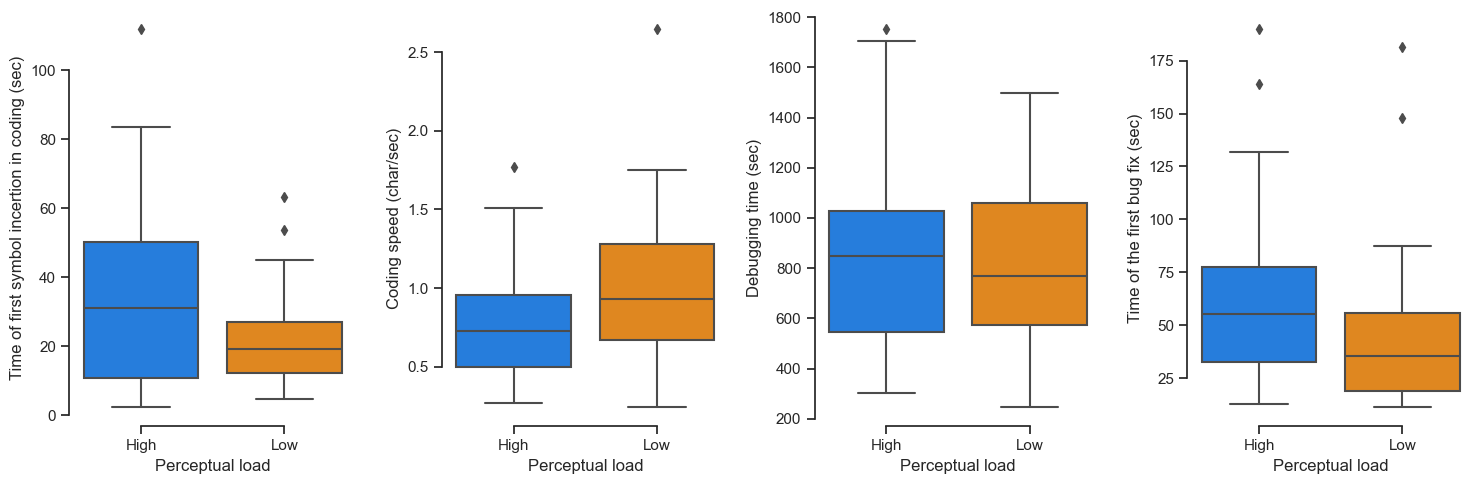

In [129]:
sns.set(style="ticks", context='notebook')
jb_colors = ['#087CFA', '#FF8900']
customPalette = sns.set_palette(sns.color_palette(jb_colors))


fig, axes = plt.subplots(1, 4, figsize=(15, 5))

y_labels = ['Time of first symbol incertion in coding (sec)',
            'Coding speed (char/sec)',
            'Debugging time (sec)',
            'Time of the first bug fix (sec)'
            ]

for i in range(4):
    plot = sns.boxplot(ax=axes[i], data=df, x='util_is_zenmode', y=ttest_factors[i], palette=customPalette)
    axes[i].set(ylabel=y_labels[i], xlabel="Perceptual load")
    axes[i].set_xticklabels(["High", "Low"])

sns.despine(trim=True)
plt.tight_layout()

plt.savefig('images/ttest_results.pdf', dpi=600)

## Hypothesis 2.1
#### Perceptual load mode and the impairment of executive functions together affect the efficiency of the tasks’ solution.


In [ ]:
anova_results = []

In [22]:
# columns with adhd measures
adhd_measures = [i for i in df.columns if '_sum' in i]

In [107]:
# results for ANOVA for coding efficiency measures
for factor in adhd_measures:
    for component in coding_factors:
        aov = pg.mixed_anova(dv=component, between=factor, within='util_is_zenmode', subject='util_email', data=df)
        if (aov.loc[aov.Source=='Interaction', 'p-unc'] < 0.05).bool():
            print(f'ADHD FACTOR: {factor}, EFFICIENCY FACTOR: {component}')
            anova_results.append([factor, component])
            print(aov)

ADHD FACTOR: restraint_sum, EFFICIENCY FACTOR: coding_first_symbol_time
            Source           SS  DF1  DF2           MS         F     p-unc  \
0    restraint_sum  2138.573129    1   34  2138.573129  4.526630  0.040705   
1  util_is_zenmode  2658.614587    1   34  2658.614587  8.568852  0.006060   
2      Interaction  1819.958878    1   34  1819.958878  5.865821  0.020920   

        np2  eps  
0  0.117494  NaN  
1  0.201294  1.0  
2  0.147139  NaN  
ADHD FACTOR: motivation_sum, EFFICIENCY FACTOR: coding_rows
            Source    SS  DF1  DF2    MS         F     p-unc       np2  eps
0   motivation_sum   6.4    1   34   6.4  1.074038  0.307350  0.030622  NaN
1  util_is_zenmode   4.5    1   34   4.5  1.505906  0.228194  0.042413  1.0
2      Interaction  16.9    1   34  16.9  5.655512  0.023164  0.142616  NaN


In [108]:
# results for ANOVA for debugging efficiency measures
for factor in adhd_measures:
    for component in debugging_factors:
        aov = pg.mixed_anova(dv=component, between=factor, within='util_is_zenmode', subject='util_email', data=df)
        if (aov.loc[aov.Source=='Interaction', 'p-unc'] < 0.05).bool():
            print(f'ADHD FACTOR: {factor}, EFFICIENCY FACTOR: {component}')
            anova_results.append([factor, component])
            print(aov)

ADHD FACTOR: management_sum, EFFICIENCY FACTOR: debugging_first_bug_time
            Source            SS  DF1  DF2            MS         F     p-unc  \
0   management_sum   1135.967173    1   34   1135.967173  0.804292  0.376120   
1  util_is_zenmode   5481.027550    1   34   5481.027550  3.741965  0.061419   
2      Interaction  10899.212732    1   34  10899.212732  7.441028  0.010014   

        np2  eps  
0  0.023109  NaN  
1  0.099146  1.0  
2  0.179557  NaN  
ADHD FACTOR: motivation_sum, EFFICIENCY FACTOR: debugging_first_bug_time
            Source           SS  DF1  DF2           MS         F     p-unc  \
0   motivation_sum  1427.280214    1   34  1427.280214  1.016716  0.320422   
1  util_is_zenmode  5481.027550    1   34  5481.027550  3.587105  0.066763   
2      Interaction  8749.221708    1   34  8749.221708  5.726003  0.022384   

        np2  eps  
0  0.029035  NaN  
1  0.095434  1.0  
2  0.144137  NaN  


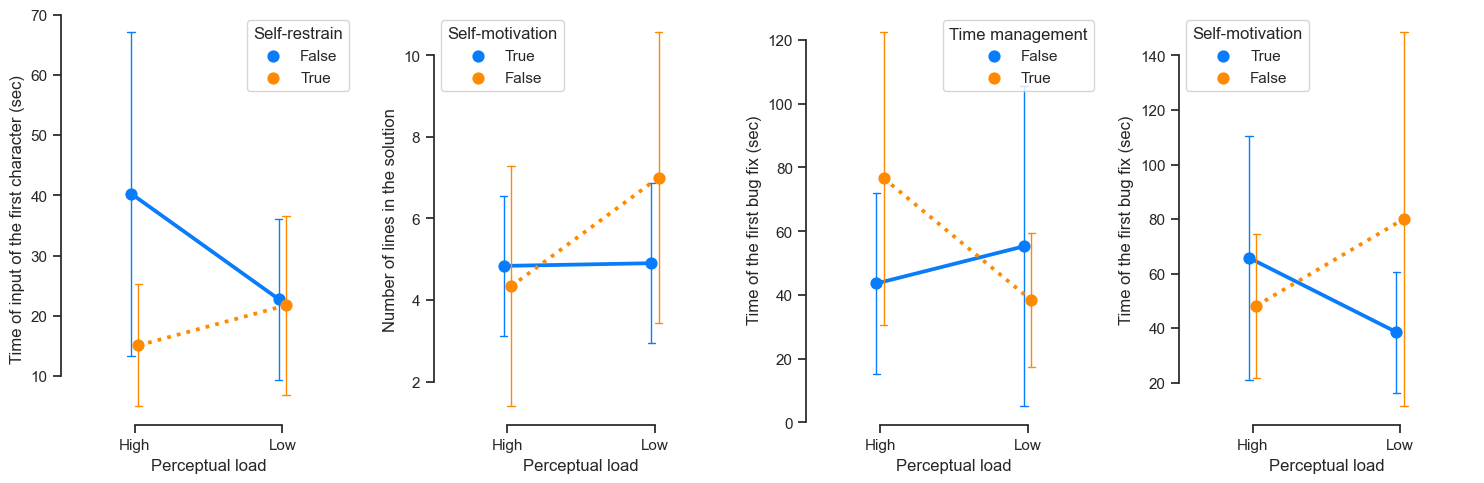

In [110]:
# plot the results
y_labeles = ['Time of input of the first character (sec)',
             'Number of lines in the solution',
             'Time of the first bug fix (sec)',
             'Time of the first bug fix (sec)']

legend_labels = ['Self-restrain',
                 'Self-motivation',
                 'Time management',
                 'Self-motivation']

sns.set(style="ticks", context='notebook')
jb_colors = ['#087CFA', '#FF8900']
customPalette = sns.set_palette(sns.color_palette(jb_colors))


fig, axes = plt.subplots(1, 4, figsize=(15, 5))


# plot_1
for i in range(4):
    maped_df = df.copy()
    maped_df[anova_results[i][0]] = maped_df[anova_results[i][0]].map({0: 'False', 1: 'True'})

    plot = sns.pointplot(ax=axes[i], x='util_is_zenmode', y=anova_results[i][1], hue=anova_results[i][0], data=maped_df,
                       linestyles=["-", ":"], errorbar='sd', errwidth=1, capsize=.05, dodge=True)
    axes[i].set(ylabel=y_labeles[i], xlabel="Perceptual load")
    axes[i].set_xticklabels(["High", "Low"])
    plot.legend(title=legend_labels[i])


sns.despine(trim=True)
plt.tight_layout()
plt.savefig('images/anova_results.pdf', dpi=600)

## H2.2
### There is a difference in the ratio of efficiency for people with and without ADHD symptoms.

In [40]:
def mwu_results(data, delta_data, adhd_measure, efficiency_factors, h_alternative):
    """
    Computes One Sided Mann-Whitney U Test and print stats if p<0.05
    """
    for factor in adhd_measure:
        # get ids for groups with ADHD symptoms
        adhd_group_names = data.loc[df[factor]==1, 'util_email'].unique()
        control_group_names = data.loc[df[factor]==0, 'util_email'].unique()
        for component in efficiency_factors:
            # get efficiency measures for each group
            adhd_group = delta_data.loc[delta_data.util_email.isin(adhd_group_names), component]
            control_group = delta_data.loc[delta_data.util_email.isin(control_group_names), component]
            res = pg.mwu(adhd_group.tolist(), control_group.tolist(), alternative=h_alternative)

            if res.loc['MWU', 'p-val'] < 0.05:
                print(f'ADHD FACTOR: {factor}, EFFICIENCY FACTOR: {component}')
                print(f'n_adhd={len(adhd_group_names)},'
                      f'mean_adhd={adhd_group.mean().round(2)},std_adhd={adhd_group.std().round(2)}')
                print(f'n_control={len(control_group_names)},mean_control={control_group.mean().round(2)},std_control={control_group.std().round(2)}')
                print(res)


In [43]:
# results for code task
mwu_results(df, code_factors_deltas, adhd_measures, coding_factors, 'less')

ADHD FACTOR: restraint_sum, EFFICIENCY FACTOR: coding_first_symbol_time
n_adhd=8,mean_adhd=0.9,std_adhd=0.62
n_control=28,mean_control=2.07,std_control=1.64
     U-val alternative     p-val       RBC      CLES
MWU   57.0        less  0.019019  0.491071  0.745536


In [46]:
# results for debugging task
mwu_results(df, debugging_factors_deltas, adhd_measures, debugging_factors, 'greater')

ADHD FACTOR: management_sum, EFFICIENCY FACTOR: debugging_first_bug_time
n_adhd=21,mean_adhd=2.62,std_adhd=2.12
n_control=15,mean_control=1.41,std_control=1.14
     U-val alternative     p-val       RBC      CLES
MWU  210.0     greater  0.047572 -0.333333  0.666667


In [47]:
# results for debugging task
mwu_results(df, debugging_factors_deltas, adhd_measures, debugging_factors, 'less')

ADHD FACTOR: organization_sum, EFFICIENCY FACTOR: debugging_diffs
n_adhd=14,mean_adhd=0.97,std_adhd=0.35
n_control=22,mean_control=1.2,std_control=0.45
     U-val alternative    p-val       RBC      CLES
MWU   98.0        less  0.03578  0.363636  0.681818
ADHD FACTOR: restraint_sum, EFFICIENCY FACTOR: debugging_events_count
n_adhd=8,mean_adhd=0.61,std_adhd=0.45
n_control=28,mean_control=1.31,std_control=0.93
     U-val alternative     p-val       RBC      CLES
MWU   59.0        less  0.022869  0.473214  0.736607
ADHD FACTOR: regulation_sum, EFFICIENCY FACTOR: debugging_time
n_adhd=4,mean_adhd=0.84,std_adhd=0.15
n_control=32,mean_control=1.25,std_control=0.44
     U-val alternative     p-val      RBC      CLES
MWU   26.0        less  0.029505  0.59375  0.796875
ADHD FACTOR: regulation_sum, EFFICIENCY FACTOR: debugging_diffs
n_adhd=4,mean_adhd=0.7,std_adhd=0.2
n_control=32,mean_control=1.16,std_control=0.42
     U-val alternative     p-val       RBC      CLES
MWU   19.0        less  0.01